In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import os

# =========================================================
# ⚙️ KONFIGURASI
# =========================================================
FOLDER_DATA = "/work/open_meteo_climate"
NAMA_FILE = "kebumen_75tahun_lengkap.csv" 
PATH_FILE = os.path.join(FOLDER_DATA, NAMA_FILE)

In [7]:
# =========================================================
# 1. LOAD DATA (MEMUAT DATA)
# =========================================================
def load_data(filepath):
    print(f"📂 Mencoba membuka file: {filepath}")
    if not os.path.exists(filepath):
        print(f"❌ File tidak ditemukan di path tersebut.")
        return None
    
    try:
        # 1. Baca CSV (Jangan pakai parse_dates di sini dulu biar aman)
        df = pd.read_csv(filepath, index_col='date')
        
        # 2. KONVERSI PAKSA KE DATETIME (Kunci Perbaikan)
        # utc=True agar seragam dulu, errors='coerce' biar data error jadi NaT
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
        
        # 3. Konversi ke WIB (Asia/Jakarta)
        df.index = df.index.tz_convert('Asia/Jakarta')
        
        # 4. HAPUS INFO ZONA WAKTU (Make it Timezone-Naive)
        # Ini triknya! Kita buang embel-embel "+07:00" tapi jamnya tetap jam WIB.
        # Ini bikin slicing df.loc['2022'] jadi lancar jaya.
        df.index = df.index.tz_localize(None)
        
        # 5. Urutkan Index (Wajib buat slicing)
        df = df.sort_index()
        
        print(f"✅ Data berhasil dimuat & dikonversi! Total: {len(df)} baris.")
        print(f"   Rentang: {df.index.min()} s.d {df.index.max()}")
        return df
        
    except Exception as e:
        print(f"❌ Gagal memproses data: {e}")
        return None

# =========================================================
# 2. STATISTIK DASAR (DESCRIPTIVE)
# =========================================================
def show_basic_stats(df):
    print("\n--- 📊 STATISTIK DASAR ---")
    # Hanya ambil kolom numerik untuk statistik
    stats = df[['temperature', 'rain_mm']].describe().T 
    print(stats[['mean', 'min', 'max', 'std']])
    
    # Total Hujan (Akumulasi) dalam dataset
    total_hujan = df['rain_mm'].sum()
    print(f"\n🌧️ Total Curah Hujan (Seluruh Dataset): {total_hujan:.2f} mm")
# =========================================================
# 3. FUNGSI HITUNG HUJAN
# =========================================================
def cek_total_hujan(df, target_waktu):
    """
    Menghitung total hujan berdasarkan input string waktu.
    Bisa input Tahun ("2024") atau Bulan ("2024-11").
    """
    print(f"\n🔎 Menganalisis Data Periode: {target_waktu} ...")
    
    try:
        # 1. Ambil Potongan Data (Slicing)
        subset = df.loc[target_waktu]
        
        if subset.empty:
            print("⚠️ Data tidak ditemukan untuk periode ini.")
            return

        # 2. Hitung Total (SUM)
        total_hujan = subset['rain_mm'].sum()
        
        # 3. Tampilkan Hasil
        print("="*40)
        print(f"🌧️ TOTAL CURAH HUJAN: {total_hujan:.2f} mm")
        print("="*40)

        # --- FITUR TAMBAHAN: BREAKDOWN ---
        
        # KASUS A: Jika Inputnya TAHUN (Panjang string 4, misal "2022")
        if len(str(target_waktu)) == 4:
            print(f"📅 Rincian Bulanan Tahun {target_waktu}:")
            print("-" * 30)
            # Resample per Bulan ('M') dan jumlahkan
            bulanan = subset['rain_mm'].resample('M').sum()
            
            for tgl, nilai in bulanan.items():
                nama_bulan = tgl.strftime('%B')
                # Kasih label kategori BMKG sederhana
                kategori = "Kering" if nilai < 100 else "Basah" if nilai > 200 else "Menengah"
                print(f"   - {nama_bulan:<10} : {nilai:>6.2f} mm  [{kategori}]")
                
        # KASUS B: Jika Inputnya BULAN (Panjang string 7, misal "2022-11")
        elif len(str(target_waktu)) == 7:
            print(f"📅 Rincian Harian Bulan {target_waktu}:")
            print("-" * 30)
            # Resample per Hari ('D') dan jumlahkan
            harian = subset['rain_mm'].resample('D').sum()
            
            # Tampilkan cuma hari yang hujan saja (biar gak panjang banget)
            hari_hujan = harian[harian > 0]
            
            if hari_hujan.empty:
                print("   (Tidak ada hujan sama sekali bulan ini)")
            else:
                for tgl, nilai in hari_hujan.items():
                    tgl_str = tgl.strftime('%d-%b')
                    print(f"   - Tgl {tgl_str:<6} : {nilai:>6.2f} mm")
                
                # Cari hari paling basah
                max_day = hari_hujan.idxmax()
                max_val = hari_hujan.max()
                print("-" * 30)
                print(f"🌊 Hujan Terderas: Tgl {max_day.strftime('%d')} ({max_val:.2f} mm)")

    except KeyError:
        print(f"❌ Format waktu salah. Gunakan 'YYYY' atau 'YYYY-MM'.")
    except Exception as e:
        print(f"⚠️ Error: {e}")

# =========================================================
# 4. FUNGSI PLOTTING
# =========================================================
def plot_periode_tertentu(df, target_waktu):
    """
    Memplot data cuaca berdasarkan filter waktu tertentu.
    """
    print(f"\n🔍 Mencari data untuk periode: {target_waktu}...")
    
    try:
        # --- SLICING (FILTER DATA) ---
        # Menggunakan partial string indexing pandas
        subset = df.loc[target_waktu]
        
        if subset.empty:
            print("❌ Data kosong! Tanggal tersebut tidak ada dalam dataset.")
            return

        # --- SETUP PLOT ---
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # --- PLOT SUHU (GARIS) ---
        ax1.plot(subset.index, subset['temperature'], 
                 color='darkorange', marker='.', linestyle='-', linewidth=1.5, label='Suhu (°C)')
        ax1.set_ylabel('Suhu (°C)', color='darkorange', fontweight='bold')
        ax1.tick_params(axis='y', labelcolor='darkorange')
        ax1.grid(True, linestyle='--', alpha=0.5)
        
        # --- PLOT HUJAN (BATANG) ---
        ax2 = ax1.twinx()
        
        # Logika lebar batang: Harian lebih lebar, Bulanan/Tahunan lebih tipis
        # Jika panjang string target > 7 (misal "2022-10-20"), berarti Harian
        width = 0.04 if len(str(target_waktu)) > 7 else 0.5 
        
        ax2.bar(subset.index, subset['rain_mm'], 
                color='dodgerblue', alpha=0.4, width=width, label='Hujan (mm)')
        ax2.set_ylabel('Hujan (mm)', color='dodgerblue', fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='dodgerblue')
        
        # --- FORMAT SUMBU X (WAKTU) OTOMATIS ---
        if len(str(target_waktu)) > 7: # Format Harian (YYYY-MM-DD)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax1.set_xlabel('Jam (WIB)')
            judul = f"Cuaca Detail Tanggal: {target_waktu}"
        elif len(str(target_waktu)) == 7: # Format Bulanan (YYYY-MM)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
            ax1.set_xlabel('Tanggal')
            judul = f"Tren Cuaca Bulan: {target_waktu}"
        else: # Format Tahunan (YYYY)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax1.set_xlabel('Bulan')
            judul = f"Tren Cuaca Tahun: {target_waktu}"

        plt.title(judul, fontweight='bold', fontsize=14)
        
        # Menggabungkan legend
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
    except KeyError:
        print(f"❌ Format tanggal salah atau data tidak ditemukan untuk: {target_waktu}")
    except Exception as e:
        print(f"⚠️ Terjadi error saat plotting: {e}")

📂 Mencoba membuka file: /work/open_meteo_climate/kebumen_75tahun_lengkap.csv
✅ Data berhasil dimuat & dikonversi! Total: 665472 baris.
   Rentang: 1950-01-01 01:00:00 s.d 2025-11-30 23:00:00

--- 📊 STATISTIK DASAR ---
                  mean     min     max       std
temperature  25.093290  15.645  33.495  2.207823
rain_mm       0.272365   0.000  61.000  0.815027

🌧️ Total Curah Hujan (Seluruh Dataset): 181251.20 mm

--- 🎨 MULAI VISUALISASI ---

🔍 Mencari data untuk periode: 2025-11-30...


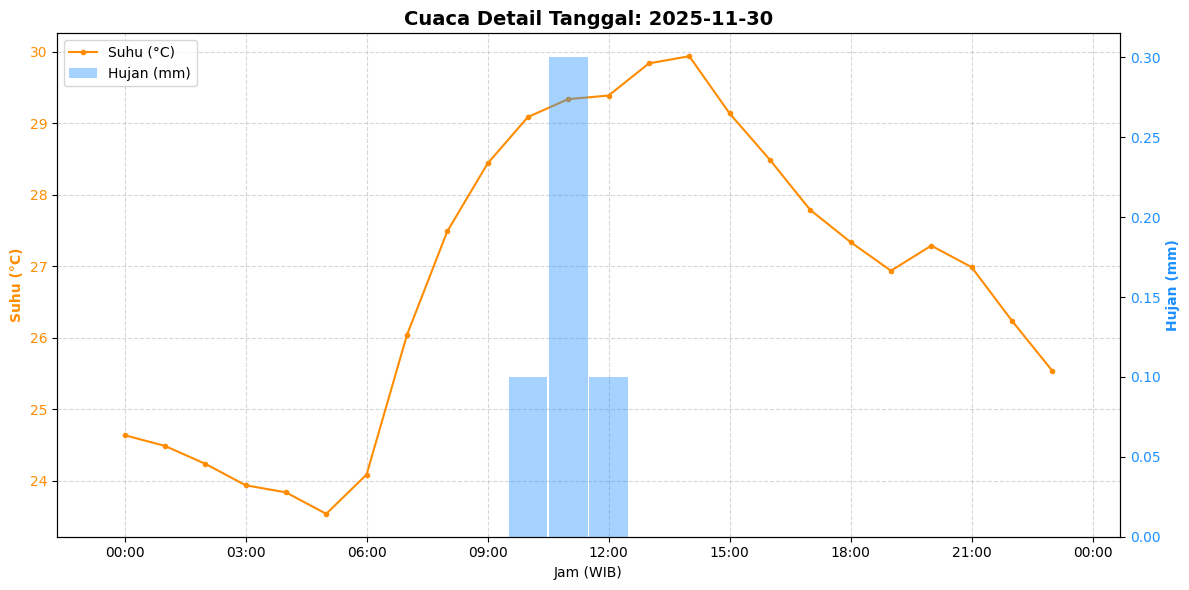


🔎 Menganalisis Data Periode: 2025-11 ...
🌧️ TOTAL CURAH HUJAN: 460.00 mm
📅 Rincian Harian Bulan 2025-11:
------------------------------
   - Tgl 01-Nov :   8.90 mm
   - Tgl 02-Nov :   9.80 mm
   - Tgl 03-Nov :   8.20 mm
   - Tgl 04-Nov :   6.00 mm
   - Tgl 05-Nov :  11.70 mm
   - Tgl 06-Nov :  19.60 mm
   - Tgl 07-Nov :   2.60 mm
   - Tgl 08-Nov :  32.50 mm
   - Tgl 09-Nov :   6.50 mm
   - Tgl 10-Nov :  21.80 mm
   - Tgl 11-Nov :  32.50 mm
   - Tgl 12-Nov :  38.90 mm
   - Tgl 13-Nov :  22.70 mm
   - Tgl 14-Nov :  12.90 mm
   - Tgl 15-Nov :  17.40 mm
   - Tgl 16-Nov :  10.30 mm
   - Tgl 17-Nov :   9.90 mm
   - Tgl 18-Nov :  20.10 mm
   - Tgl 19-Nov :  70.20 mm
   - Tgl 20-Nov :  32.30 mm
   - Tgl 21-Nov :  11.40 mm
   - Tgl 22-Nov :   1.80 mm
   - Tgl 23-Nov :  13.90 mm
   - Tgl 24-Nov :  26.70 mm
   - Tgl 25-Nov :   0.90 mm
   - Tgl 26-Nov :   5.80 mm
   - Tgl 27-Nov :   2.00 mm
   - Tgl 28-Nov :   1.20 mm
   - Tgl 29-Nov :   1.00 mm
   - Tgl 30-Nov :   0.50 mm
-----------------------

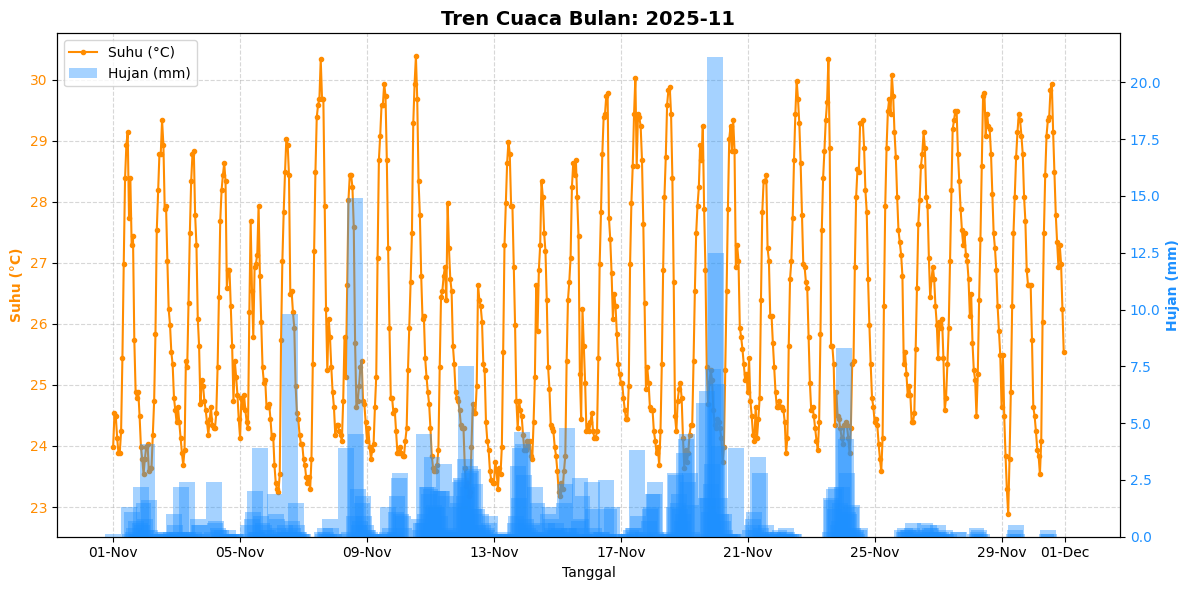


🔍 Mencari data untuk periode: 2025...


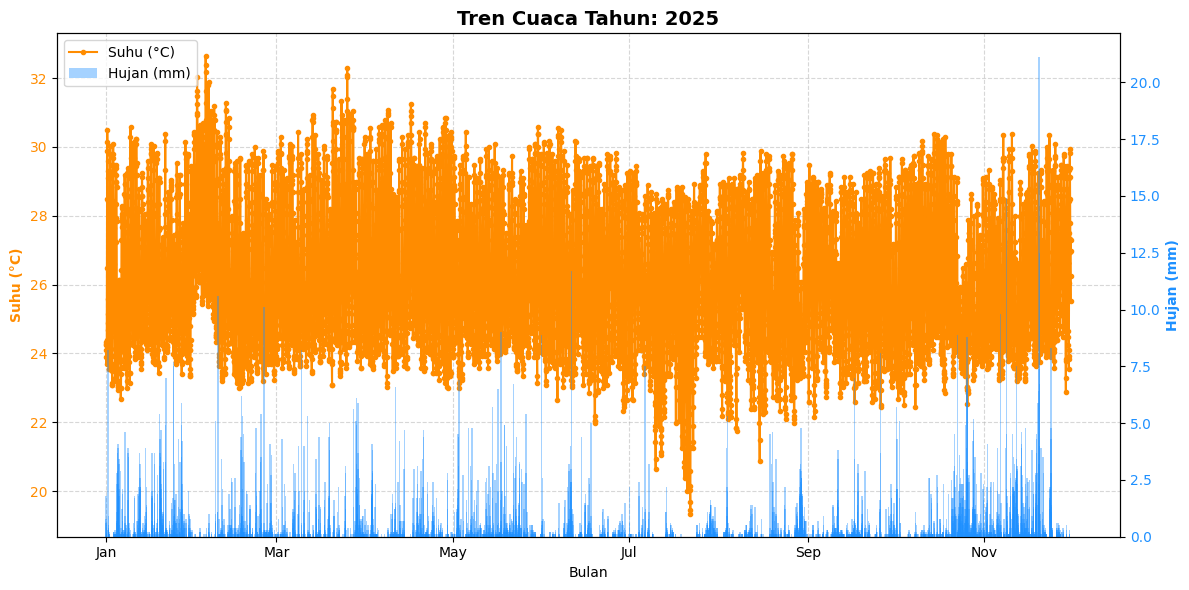

In [13]:
# =========================================================
# EKSEKUSI UTAMA (MAIN)
# =========================================================
if __name__ == "__main__":
    # 1. Load Data Sekali Saja
    df_cuaca = load_data(PATH_FILE)
    
    # Pastikan data berhasil dimuat sebelum lanjut
    if df_cuaca is not None:
        
        # 2. Tampilkan Statistik Umum
        show_basic_stats(df_cuaca)
        
        # 3. Visualisasi Sesuai Request
        print("\n--- 🎨 MULAI VISUALISASI ---")
        
        # Contoh 1: Lihat Detail SATU HARI (24 Jam)
        # Pastikan tanggal ini ada di data CSV kamu
        plot_periode_tertentu(df_cuaca, "2025-11-30")
        cek_total_hujan(df_cuaca, "2025-11")

        # Contoh 2: Lihat Tren SATU BULAN (30 Hari)
        plot_periode_tertentu(df_cuaca, "2025-11")

        # Contoh 3: Lihat Tren SATU TAHUN (12 Bulan)
        plot_periode_tertentu(df_cuaca, "2025")

In [1]:
df_cuaca.tail(10)

NameError: name 'df_cuaca' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=672c3bf7-b636-46e8-b7c0-4f6feec29313' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>